# 실습01. 이미지 분류기에 전이학습 적용하기 - (2) 세분화된 분류기 만들기

- 실습 01_01은 개인지 분류하는 것이었다면, 실습 01_02에서는 개 품종을 분류
- 위키독스 코드 참조
    - [EDA](https://github.com/wikibook/transfer-learning/blob/master/Chapter06/Dog_Breed_EDA.ipynb)
    - [모델링](https://github.com/wikibook/transfer-learning/blob/master/Chapter06/Dog_Breed_Transfer_Learning_Classifier.ipynb)

# 캐글에서 개 품종 데이터 받기

- 데이터 제공 URL: https://www.kaggle.com/competitions/dog-breed-identification/overview

In [1]:
# # API로 데이터 받기
# !kaggle competitions download -c dog-breed-identification

In [2]:
# # 위에서 받은 데이터 압축 풀기
# !unzip dog-breed-identification.zip -d ./data

In [3]:
import os
import scipy as sp
import numpy as np
import pandas as pd

import PIL
import scipy.ndimage as spi

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [4]:
from PIL import Image

def resize_image(image, target_size):
    img = Image.fromarray(image)
    img_resized = img.resize(target_size)
    return np.array(img_resized)

In [5]:
import imageio

# This function prepares a random batch from the dataset
def load_batch(dataset_df, batch_size = 25):
    batch_df = dataset_df.loc[np.random.permutation(np.arange(0,
                                                              len(dataset_df)))[:batch_size],:]
    return batch_df

# This function plots sample images in specified size and in defined grid
def plot_batch(images_df, grid_width, grid_height, im_scale_x, im_scale_y):
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(12, 12)
    
    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            ax[i][j].axis('off')
            ax[i][j].set_title(images_df.iloc[img_idx]['breed'][:10])
            ax[i][j].imshow(resize_image(imageio.imread(DATASET_PATH + images_df.iloc[img_idx]['id']+'.jpg'),
                                             (im_scale_x,im_scale_y)))
            img_idx += 1
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.2)

In [6]:
root_path = './data'

# 1. EDA
- 체크 포인트
    - 이미지 별 데이터 사이즈
    - 레이블 불균형도

In [7]:
# kaggle에서 데이터를 받아야 함
# https:/​/​www. kaggle.​com/​c/​dog-​breed-​identification/​data
# 파일을 받은 후 특정 디렉토리에 train.zip및 train.csv.zip파일을 압축해제한다.
# 그 디렉토리와 파일을 아래에 기술한다.
DATASET_PATH = os.path.join(root_path, 'train/')
LABEL_PATH = os.path.join(root_path, 'labels.csv')

dataset_df = pd.read_csv(LABEL_PATH)

print(dataset_df.sample(3))
dataset_df.shape

                                    id               breed
2882  475171ec5847e4df41847e295b8cfca2         toy_terrier
4514  70c412a3ce894c617cbe707f24adbb82        irish_setter
7717  c13427fc3db9194dac02b1721bd10fe4  scottish_deerhound


(10222, 2)

- 일부 이미지만 추출해 확인하기

/var/folders/ff/dhzsmdj11kz5k0h68nl3mj3r0000gn/T/ipykernel_4177/208888818.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax[i][j].imshow(resize_image(imageio.imread(DATASET_PATH + images_df.iloc[img_idx]['id']+'.jpg'),


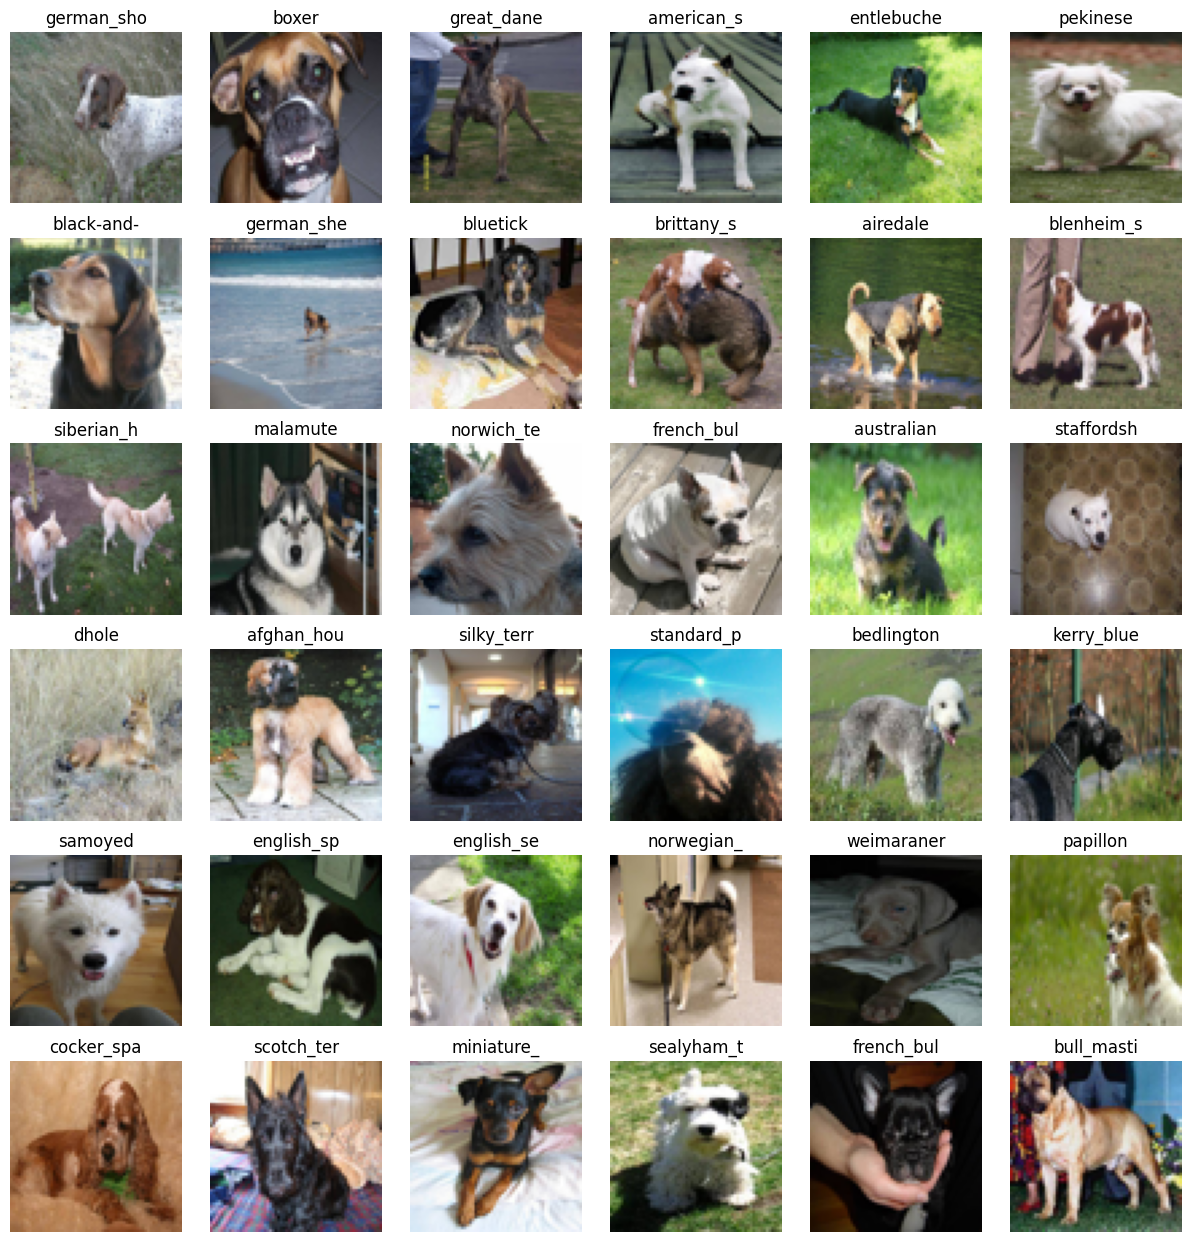

In [8]:
batch_df = load_batch(dataset_df, 
                    batch_size=36)
plot_batch(batch_df, grid_width=6, grid_height=6
           ,im_scale_x=64, im_scale_y=64)

## 1.a 이미지 사이즈 분포 확인

In [9]:
file_list = os.listdir(DATASET_PATH)
file_dimension_list = np.asarray([imageio.imread(DATASET_PATH + file).shape for file in file_list])
shape_df = pd.DataFrame(file_dimension_list,columns=['width','height','channel'])

/var/folders/ff/dhzsmdj11kz5k0h68nl3mj3r0000gn/T/ipykernel_4177/4249899829.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  file_dimension_list = np.asarray([imageio.imread(DATASET_PATH + file).shape for file in file_list])


In [10]:
# 가로, 세로, RGB 텐서
file_dimension_list

array([[430, 500,   3],
       [300, 400,   3],
       [350, 272,   3],
       ...,
       [375, 500,   3],
       [333, 500,   3],
       [375, 500,   3]])

- 이미지 별 이미지 사이즈가 제각각

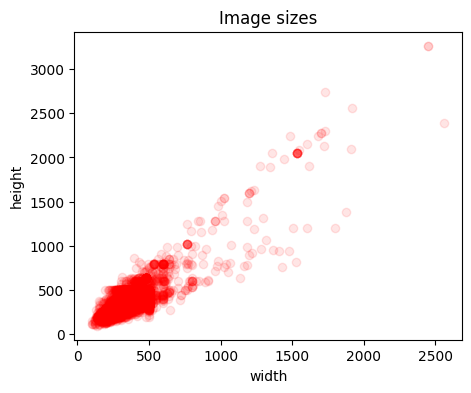

In [11]:
plt.figure(figsize=(5,4))
plt.plot(file_dimension_list[:,0],
            file_dimension_list[:,1], "ro", alpha=0.1)
plt.title("Image sizes")
plt.xlabel("width")
plt.ylabel("height")
plt.show()

## 1.b 레이블 불균형 체크
- 품종 레이블 별 데이터 수
    - 데이터 수가 적은 레이블의 경우 이미지 70장, 데이터 수가 많은 레이블의 경우 이미지 120장까지 있음

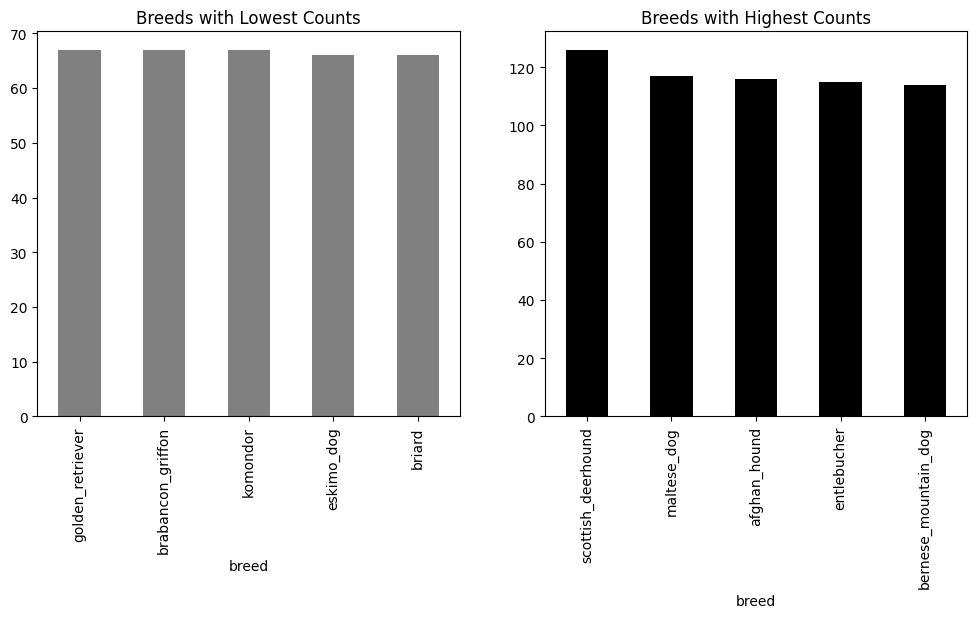

In [12]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(1,2, 1)
dataset_df.breed.value_counts().tail().plot(kind='bar',
                                            ax=ax1,
                                            color='gray',
                                            title="Breeds with Lowest Counts")

ax2 = fig.add_subplot(1,2, 2)
dataset_df.breed.value_counts().head().plot(kind='bar',
                                            ax=ax2,
                                            color='black',
                                            title="Breeds with Highest Counts")
plt.show()

# 2. 학습셋, 테스트셋 불러오기

In [13]:
import os
import math
import pathlib
import shutil

from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Conv2D,MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense,Flatten
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.utils import to_categorical

In [14]:
train_folder = os.path.join(root_path, 'train/')
test_folder = os.path.join(root_path, 'test/')

In [15]:
data_labels = pd.read_csv(root_path + '/labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [16]:
target_labels = data_labels['breed']
print('학습셋 내 개 품종 수:', len(set(target_labels)))

학습셋 내 개 품종 수: 120


- 개 품종 레이블 원핫인코딩

In [17]:
# sparse는 희소 행렬을 사용할지 여부를 결정하는 매개변수입니다. 
# 희소 행렬은 대부분의 값이 0인 행렬을 효과적으로 표현하는 방법으로, 메모리를 효율적으로 사용할 수 있습니다.
label_encode = pd.get_dummies(target_labels, sparse=True)

In [18]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./data/practice01_02/train/000bec180eb18c7604d...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./data/practice01_02/train/001513dfcb2ffafc82c...
2,001cdf01b096e06d78e9e5112d419397,pekinese,./data/practice01_02/train/001cdf01b096e06d78e...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./data/practice01_02/train/00214f311d5d2247d5d...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./data/practice01_02/train/0021f9ceb3235effd7f...


- 일정한 크기의 사이즈(299 x 299)로 이미지를 읽는다.

In [19]:
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(299, 299))
                       ) for img 
                           in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

# 3. 데이터 분할(학습, 테스트, 검증셋)

In [20]:
# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [30]:
print(f"학습셋 크기: {x_train.shape}")
print(f"테스트셋 크기: {x_test.shape}")
print(f"검증셋 크기: {x_val.shape}")

학습셋 크기: (6081, 299, 299, 3)
테스트셋 크기: (3067, 299, 299, 3)
검증셋 크기: (1074, 299, 299, 3)


In [31]:
y_train_encode = pd.get_dummies(y_train.reset_index(drop=True)).values
y_val_encode = pd.get_dummies(y_val.reset_index(drop=True)).values
y_test_encode = pd.get_dummies(y_test.reset_index(drop=True)).values

# 4. 데이터 수 늘리기

In [24]:
BATCH_SIZE = 32

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(X_train, 
                                     y_train_encode, 
                                     shuffle=False, 
                                     batch_size=BATCH_SIZE, 
                                     seed=1)

# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(X_val, 
                                   y_val_encode, 
                                   shuffle=False, 
                                   batch_size=BATCH_SIZE, 
                                   seed=1)

In [25]:
X_train[0,:,:,:]

array([[[132., 154.,  92.],
        [107., 128.,  69.],
        [132., 153.,  94.],
        ...,
        [158., 118.,  93.],
        [149., 109.,  84.],
        [110.,  70.,  44.]],

       [[125., 145.,  86.],
        [ 95., 115.,  56.],
        [116., 136.,  77.],
        ...,
        [153., 113.,  88.],
        [138.,  98.,  73.],
        [110.,  70.,  44.]],

       [[123., 140.,  85.],
        [111., 128.,  73.],
        [112., 127.,  72.],
        ...,
        [149., 109.,  84.],
        [126.,  86.,  61.],
        [112.,  72.,  46.]],

       ...,

       [[ 67.,  86.,  67.],
        [ 56.,  75.,  56.],
        [ 53.,  72.,  52.],
        ...,
        [ 54.,  44.,  52.],
        [ 58.,  48.,  56.],
        [ 64.,  54.,  62.]],

       [[ 64.,  83.,  63.],
        [ 55.,  74.,  54.],
        [ 53.,  72.,  52.],
        ...,
        [ 55.,  48.,  55.],
        [ 60.,  53.,  60.],
        [ 65.,  58.,  65.]],

       [[ 61.,  80.,  60.],
        [ 55.,  74.,  54.],
        [ 53.,  

# 5. 전이학습 모델 구축

- Inception3 사전학습 모델로 베이스 모델 구축(마지막 층 바로 전까지만 가져오기)

In [32]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', 
                             include_top = False,  # 마지막 층 바로 전까지만 가져오기
                             input_shape=(299, 299, 3))

# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_encode.shape[1] # 레이블 수 
predictions = Dense(total_classes, activation='softmax')(out)

- 베이스모델에서 이미 학습된 weight를 가져오려면 layer.trainable = False를 통해 베이스 모델을 고정해야 함

In [ ]:
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

# model.summary()

In [34]:
for i in range(1,7)[::-1]:  
    print(model.layers[-i].name, model.layers[-i].output_shape)

activation_187 (None, 8, 8, 192)
mixed10 (None, 8, 8, 2048)
global_average_pooling2d_1 (None, 2048)
dense_3 (None, 512)
dense_4 (None, 512)
dense_5 (None, 120)


In [35]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = X_train.shape[0] // batch_size
val_steps_per_epoch = X_val.shape[0] // batch_size

# # 주석 풀어서 학습할 것
# history = model.fit_generator(train_generator,
#                               steps_per_epoch=train_steps_per_epoch,
#                               validation_data=val_generator,
#                               validation_steps=val_steps_per_epoch,
#                               epochs=15,
#                               verbose=1)


In [36]:
# model.save('./trained_model/practice01_dog_breed.h5')

# # history 저장 (pickle을 사용)
# import pickle
# with open("./trained_model/practice01_dog_breed.pkl", "wb") as file:
#     pickle.dump(history.history, file)

In [37]:
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model("./trained_model/practice01_dog_breed.h5")

import pickle

# history 불러오기
with open("./trained_model/practice01_dog_breed.pkl", "rb") as file:
    history = pickle.load(file)

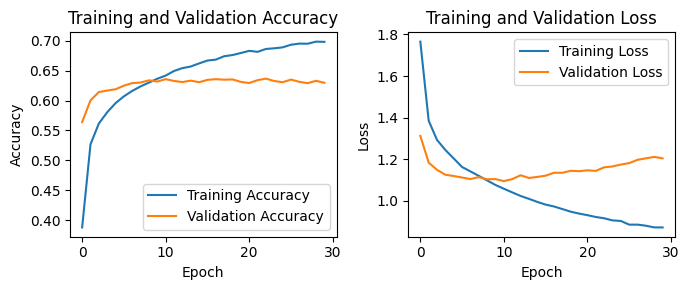

In [48]:
import pickle

# history 불러오기
with open("./trained_model/practice01_history01.pkl", "rb") as file:
    history = pickle.load(file)

# 훈련 정확도와 검증 정확도 그리기
plt.figure(figsize=(7,3))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 훈련 손실과 검증 손실 그리기
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 그림 보여주기
plt.tight_layout()
plt.show()

# 6. 전이학습 모델로 개 품종 예측하기

In [46]:
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_encode, axis=1)

96/96 [==============================] - 96s 991ms/step


- label이 많아서인지 예측이 잘 안되는 듯하다.

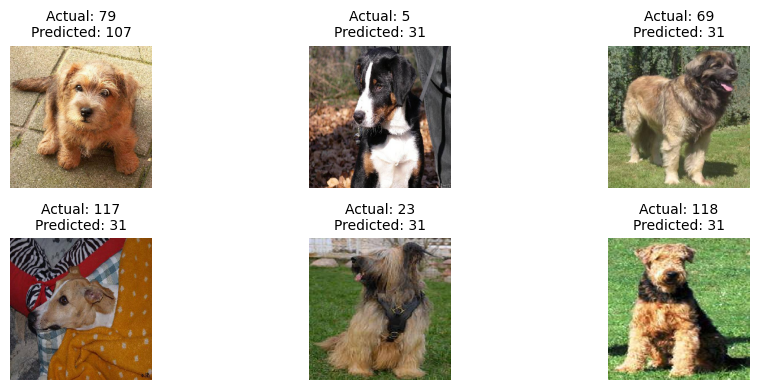

In [51]:
from sklearn.metrics import confusion_matrix
import random

# 랜덤 샘플 6개 선택
random_indices = random.sample(range(len(X_test)), 6)

# 선택한 랜덤 샘플에 대해 그림 그리기
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 3, i)
    plt.imshow(X_test[idx].astype('uint8'))
    plt.title(f"Actual: {y_true[idx]}\nPredicted: {y_pred_classes[idx]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# E.O.D.